In [432]:
import time
from copy import deepcopy

import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [433]:
dataset = pd.read_csv('../datasets/simple.csv', header=0, usecols=['x', 'y'], names=['x', 'y'])
dataset.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


In [434]:
# Modified this template in the following ways:
# * All class and function names were changed to snake_case style.
# * An Individual's cost is calculated by a function called within the genetic algorithm (for thread optimization).

class problem:
  def __init__(self):
    self.number_of_genes = 2
    self.min = 0.001
    self.max = 0.9
    self.cost_function = None

class parameters:
  def __init__(self):
    self.population = 10
    self.maximum_number_of_generations = 100
    self.crossover_exploration = 0.1
    self.mutation_rate = 0.2
    self.mutation_range = 0.1
    self.child_factor = 1

In [435]:
# The individual is a unique linear regression model.
# All individuals use the same training, validation, and test sets.

# Create training, validation, and test sets.
    # Shuffle dataset
RANDOM_SEED = 100
SAMPLE_SIZE = 1 # TODO: params. The percentage of the dataset used in the optimization algorithm, forming the train/validate/test sets.
dataset_sampled = dataset.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED)
train_data, test_data = np.split(dataset_sampled, [int(.8 * len(dataset_sampled))])
train_data, test_data = train_data.transpose(), test_data.transpose()

class individual:
  def __init__(self, prob):
    self.problem = prob
    self.chromosome = np.random.uniform(prob.min, prob.max, prob.number_of_genes)
    self.model = SGDRegressor(
        learning_rate = 'constant',
        eta0 = self.chromosome[0], # Learning-rate
        penalty = 'l2', # Regularization type
        alpha = self.chromosome[1], # Regularization type
        max_iter = 100
    )
    self.cost = np.nan

  def crossover(self, other, epsilon):
    child1 = deepcopy(self)
    child2 = deepcopy(other)

    alpha = np.random.uniform(-epsilon,1+epsilon)
      
    child1.chromosome = alpha*self.chromosome + (1-alpha)*other.chromosome
    child2.chromosome = (1-alpha)*self.chromosome + alpha*other.chromosome
    return child1, child2

  def mutate(self,mutation_rate,mutation_range):
    for i in range(len(self.chromosome)):
      if np.random.uniform(0,1) < mutation_rate:
        self.chromosome[i] += np.random.randn()*mutation_range#np.clip(np.random.randn()*mutation_range, a_min=self.problem.min, a_max=self.problem.max)

  def calculate_cost(self):
    self.train_time = np.nan
    self.mse = np.nan

    # Fit model and calculate time-till-convergence
    start = time.perf_counter()
    self.model.fit(train_data[0].reshape(-1, 1), train_data[1])
    end = time.perf_counter()
    time_seconds = end-start
    self.train_time = time_seconds
      
    predictions = self.model.predict(test_data[0].reshape(-1, 1))
    self.mse = mean_squared_error(test_data[1], predictions)
      
    # Temporary idea, mse (already a 'cost' function) is amplified by time
    self.cost = self.mse * (1 + time_seconds)
    return self.cost

In [436]:
# TODO: Update to tournament or other method
def get_parents(population):
  index1 = np.random.randint(0, len(population))
  index2 = np.random.randint(0, len(population))
  if index1 == index2:
    return get_parents(population)
  parent1 = population[index1]
  parent2 = population[index2]
  return parent1, parent2

In [437]:
def run_genetic(prob, params):
  # Read in variables from problem and the parameters
  number_in_population = params.population
  number_of_genes = prob.number_of_genes
  cost_function = prob.cost_function
  maximum_number_of_generations = params.maximum_number_of_generations
  crossover_exploration = params.crossover_exploration
  mutation_rate = params.mutation_rate
  mutation_range = params.mutation_range
  children_per_generation = number_in_population * params.child_factor
  # Generate the initial population
  population = []
  best_solution = individual(prob)
  best_cost = np.inf
  for i in range(number_in_population):
    new_individual = individual(prob)
    new_individual.calculate_cost()
    if new_individual.cost < best_cost:
      best_cost = new_individual.cost
      best_solution = deepcopy(new_individual)
    population.append(individual(prob))
  print(f"Best initial: {best_solution.mse}")

  # Iterate from here for each generation
  for generation in range(maximum_number_of_generations):
      # produce children until correct amount
      children = []
      while len(children) < children_per_generation:
          # choose parents
          parent1, parent2 = get_parents(population)
          # mate parents
          child1, child2 = parent1.crossover(parent2,crossover_exploration)
              # mate producing 2 children (Crossover)
              # mutate the children
          child1.mutate(mutation_rate, mutation_range)
          child2.mutate(mutation_rate, mutation_range)
              # calculate child cost
          child1.calculate_cost()
          child2.calculate_cost()
          children.append(child1)
          children.append(child2)
              # add to population
      population += children
      # cull the population
      population = sorted(population, key=lambda x: x.cost)
      population = population[:number_in_population]
      if population[0].cost<best_solution.cost:
        best_solution = deepcopy(population[0])
        best_cost = best_solution.cost
        print(f"Better: {best_solution.mse}")

      
  return best_solution

In [451]:
# This individual should contain the best values to train a full model
i = individual(problem())
i.calculate_cost()
best = i#run_genetic(problem(), parameters())

train_data, test_data = np.split(dataset.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED), [int(.8 * len(dataset_sampled))])
train_data, test_data = train_data.transpose(), test_data.transpose()

model = SGDRegressor(
    learning_rate = 'constant',
    eta0 = 0.001, # Learning-rate
    penalty = 'l2', # Regularization type
    alpha = 0, # Regularization type
    max_iter = 1000
)
model
best.mse

1.8774997677820483e+30

In [452]:
start = time.perf_counter()
model.fit(train_data[0].reshape(-1, 1), train_data[1])
end = time.perf_counter()
time_seconds = end-start
  
predictions = model.predict(test_data[0].reshape(-1, 1))
mse = mean_squared_error(test_data[1], predictions)

print(f"Model trained in {time_seconds} seconds, with a MSE of {mse}")

Model trained in 0.0015229999989969656 seconds, with a MSE of 1.7269791126748609e+25


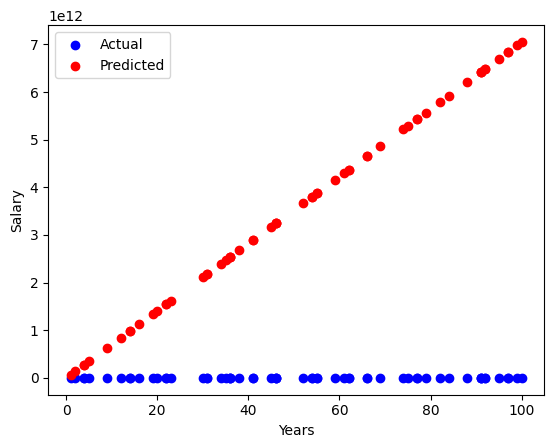

In [453]:
import matplotlib.pyplot as plt

plt.scatter(test_data[0].reshape(-1, 1), test_data[1], label='Actual', color='blue')
plt.scatter(test_data[0].reshape(-1, 1), predictions, label='Predicted', color='red')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.legend()
plt.show()